In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from lmfit import minimize, Parameters, report_fit

n_compartments = 3
source_concentration = 1
time_steps = 500
dt = 0.1
diffusion_rate = 0.2  # constant k_ij between all compartments

# init compartments
compartments = np.zeros(n_compartments)
source = source_concentration  # create inf source
concentration = []

# stolen ken code
for t in range(time_steps):
    concentration.append(np.concatenate(([source], compartments.copy())))
    
    # source ---> first compartment
    flux_source = diffusion_rate * (source - compartments[0]) * dt
    compartments[0] += flux_source

    # diffusion between compartments
    fluxes = np.zeros(n_compartments)
    for i in range(n_compartments - 1):
        flux = diffusion_rate * (compartments[i] - compartments[i + 1]) * dt
        fluxes[i] -= flux
        fluxes[i + 1] += flux
    compartments += fluxes

concentration = np.array(concentration)
time = np.linspace(0, time_steps * dt, time_steps) # time arr


In [ ]:
def sigmoid(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

def sigmoid_objective_function(params, t_obs, y_obs, compartment_idx): # sigmoid from data + interpolation
    L = params['L'].value
    k = params['k'].value
    t0 = params['t0'].value

    y_model_full = sigmoid(time, L, k, t0)
    interpolate_model = interp1d(time, y_model_full, kind='cubic', bounds_error=False, fill_value="extrapolate")
    y_model = interpolate_model(t_obs)

    return y_obs - y_model # compute residuals to minimize later



In [ ]:
def sigmoid(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

L = 1
k = 2



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 50
    # variables        = 3
    chi-square         = 0.52789570
    reduced chi-square = 0.01123182
    Akaike info crit   = -221.543978
    Bayesian info crit = -215.807909
[[Variables]]
    L:   0.88093715 +/- 0.02837854 (3.22%) (init = 1)
    k:   0.12570393 +/- 0.02366000 (18.82%) (init = 0.5)
    t0:  5.33811078 +/- 1.18968282 (22.29%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, k)  = -0.6320
    C(L, t0) = +0.3672
    C(k, t0) = +0.1366


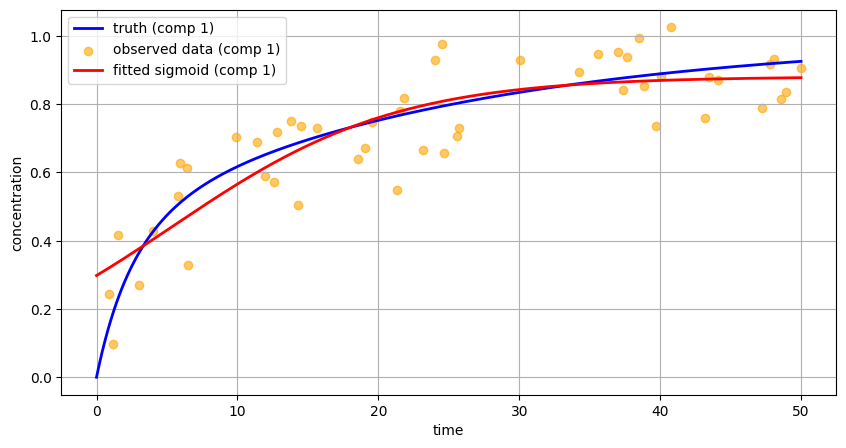

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 50
    # variables        = 3
    chi-square         = 0.61577166
    reduced chi-square = 0.01310152
    Akaike info crit   = -213.845104
    Bayesian info crit = -208.109035
[[Variables]]
    L:   0.80327980 +/- 0.03621940 (4.51%) (init = 1)
    k:   0.11139285 +/- 0.02516703 (22.59%) (init = 0.5)
    t0:  9.99999999 +/- 4.14907618 (41.49%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, k)  = -0.7304
    C(L, t0) = -0.5370
    C(k, t0) = +0.1751


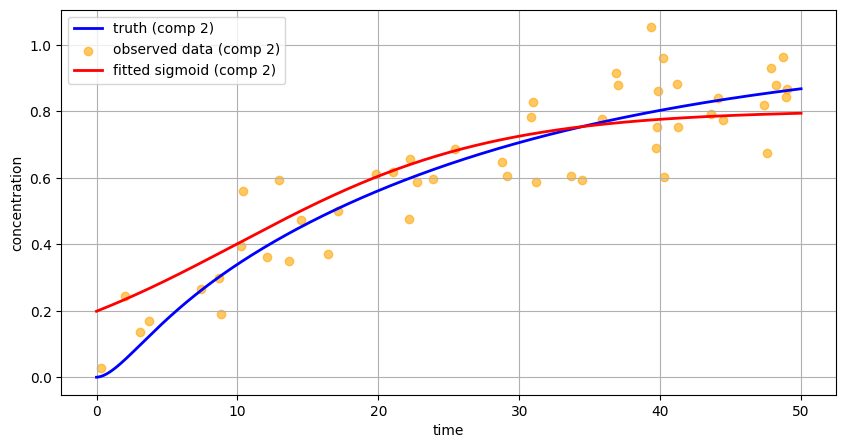

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 50
    # variables        = 3
    chi-square         = 1.09773919
    reduced chi-square = 0.02335615
    Akaike info crit   = -184.938511
    Bayesian info crit = -179.202442
[[Variables]]
    L:   0.68089513 +/- 0.04060368 (5.96%) (init = 1)
    k:   0.15020051 +/- 0.04604627 (30.66%) (init = 0.5)
    t0: 10.00000000 +/- 10.7730253 (107.73%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, k)  = -0.6222
    C(L, t0) = -0.5652
    C(k, t0) = +0.2421


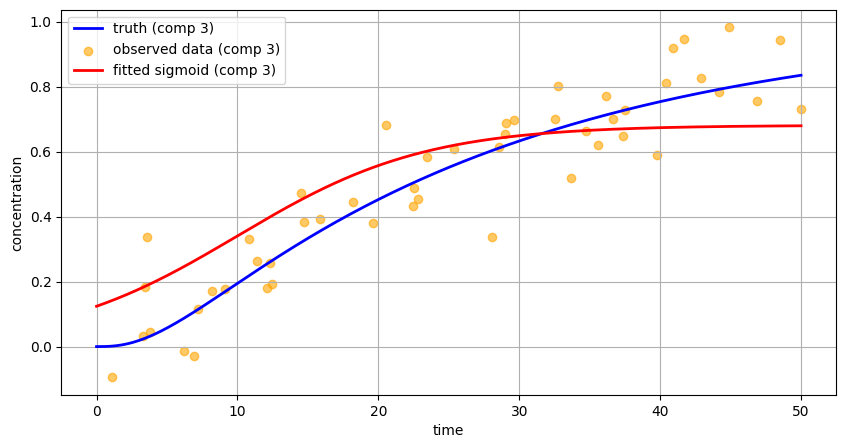

In [ ]:
n_samples = 50
rng = np.random.default_rng(seed=1)

for compartment_idx in range(1, n_compartments + 1):  # Exclude the source
    # add noise
    y_full = concentration[:, compartment_idx] + np.random.normal(scale=0.1, size=len(time))
    
    # sample obs
    sample_indices = rng.choice(len(time), size=n_samples, replace=False)
    sample_indices.sort()  # ensure order or else error
    t_obs = time[sample_indices]
    y_obs = y_full[sample_indices]

    # define sigmoid parameters
    params_sigmoid = Parameters()
    # max value was added in later because I though otherwise it looked funny
    params_sigmoid.add('L', value=1.0, min=0.5, max=2.0)  # maximum value 
    params_sigmoid.add('k', value=0.5, min=0.1, max=2.0)  # growth rate
    params_sigmoid.add('t0', value=5.0, min=0.0, max=10.0)  # timeshift

    # fit
    result_sigmoid = minimize(sigmoid_objective_function, params_sigmoid, args=(t_obs, y_obs, compartment_idx))
    report_fit(result_sigmoid)

    # create fitted sigmoid curve from new params
    y_fitted_sigmoid = sigmoid(time, result_sigmoid.params['L'], result_sigmoid.params['k'], result_sigmoid.params['t0'])
    
    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(time, concentration[:, compartment_idx], label=f"truth (comp {compartment_idx})", linewidth=2, color='blue')
    plt.scatter(t_obs, y_obs, alpha=0.6, label=f"observed data (comp {compartment_idx})", color='orange')
    plt.plot(time, y_fitted_sigmoid, label=f"fitted sigmoid (comp {compartment_idx})", linewidth=2, color='red')
    plt.xlabel("time")
    plt.ylabel("concentration")
    plt.legend()
    plt.grid()
    plt.show()

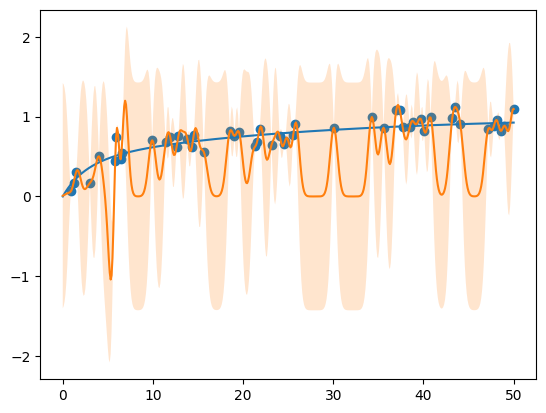

Compartment 1: L=1.1997253218389847, k=1.0635890967155115, t0=6.913827655310621


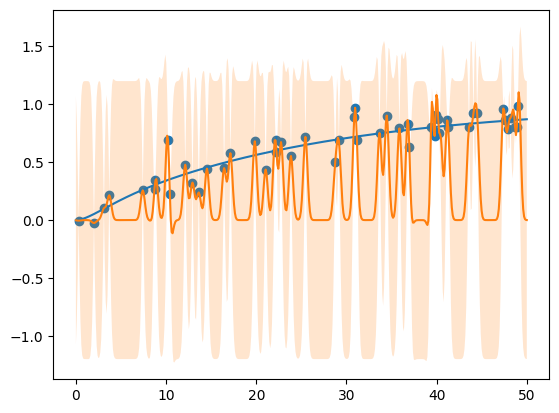

Compartment 2: L=1.099324158608584, k=0.9156126952540163, t0=49.098196392785574


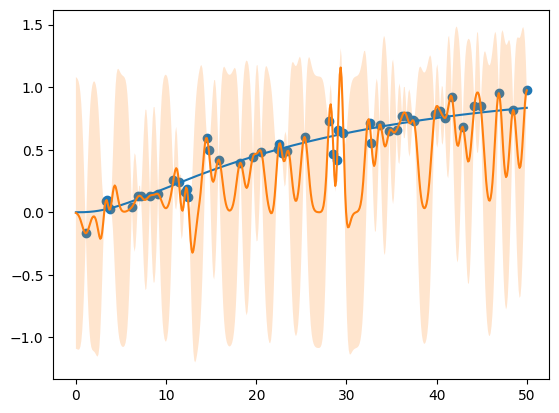

Compartment 3: L=1.1568952080587795, k=1.6739950430622308, t0=29.35871743486974


In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (0.1, 10.0)) * RBF(1.0, (0.1, 10.0))

n_samples = 50
rng = np.random.default_rng(seed=1)

for compartment_idx in range(1, n_compartments + 1):  # Exclude the source
    # add noise
    y_full = concentration[:, compartment_idx] + np.random.normal(scale=0.1, size=len(time))
    
    # sample obs
    sample_indices = rng.choice(len(time), size=n_samples, replace=False)
    sample_indices.sort()  # ensure order or else error
    t_obs = time[sample_indices]
    y_obs = y_full[sample_indices]

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(t_obs.reshape(-1, 1), y_obs)
    y_pred, y_std = gp.predict(time.reshape(-1, 1), return_std=True)

    plt.plot(time, concentration[:, compartment_idx])
    plt.scatter(t_obs, y_obs)
    plt.plot(time, y_pred)
    plt.fill_between(time, y_pred - 1.96 * y_std, y_pred + 1.96 * y_std, alpha=0.2)
    plt.show()

    # https://stackoverflow.com/questions/73827456/optimising-finding-the-index-of-the-highest-value-in-a-list
    L_gp = y_pred.max()
    t0_gp = time[np.argmax(y_pred)]
    k_gp = 1 / (y_pred[np.argmax(y_pred)] - y_pred[np.argmax(y_pred) // 2])
    print(f"Compartment {compartment_idx}: L={L_gp}, k={k_gp}, t0={t0_gp}")
